# BERT model download

In [1]:
!pwd

/home/ubuntu/exercises/Sentiment_Analysis


In [2]:
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2023-01-16 19:35:08--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.112, 34.64.4.48, 34.64.4.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M   153MB/s    in 4.3s    

2023-01-16 19:35:13 (148 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [3]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

In [4]:
import warnings
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [ ]:
os.listdir('bert')

## Download Naver's Movie Review Data

In [5]:
import urllib.request
#!git clone https://github.com/e9t/nsmc.git
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7feeebfd9940>)

In [20]:
train = pd.read_table("ratings_train.txt")
test = pd.read_table("ratings_test.txt")
#train = pd.read_table("nsmc/"+"ratings_train.txt")
#test = pd.read_table("nsmc/"+"ratings_test.txt")

print('No of data in train set :', len(train)) 
print('No of data in test set :', len(test)) 

No of data in train set : 150000
No of data in test set : 50000


In [7]:
print(train[30:40])
print(train.columns[1], train.columns[2])

         id                                           document  label
30  6331922  엄포스의 위력을 다시 한번 깨닫게 해준 적.남 꽃검사님도 연기 정말 좋았어요! 완전...      1
31  9005897                           졸쓰레기 진부하고말도안됌ㅋㅋ 아..시간아까워      0
32   164908                                   재밌는데 별점이 왜이리 낮은고      1
33  9671124                       1%라도 기대했던 내가 죄인입니다 죄인입니다....      0
34  5712231                                아직도 이 드라마는 내인생의 최고!      1
35  4726746                                 패션에 대한 열정! 안나 윈투어!      1
36  7203432                키이라 나이틀리가 연기하고자 했던건 대체 정신장애일까 틱장애일까      0
37   112724                      허허...원작가 정신나간 유령이라... 재미있겠네요!      1
38  1105872                             포스터는 있어보이는데 관객은 114명이네      0
39  4805788                           이 영화가 왜 이렇게 저평가 받는지 모르겠다      1
document label


## EDA

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def reviews_eda(df):
    #df = tfds.as_dataframe(dataset_train)  # ***dataset to dataframe***
 
    sentence = df.columns[1]
    label = df.columns[2]
    
    #bar graphs for the number of data
    #sns.set_theme(style="whitegrid")
    sns.countplot(x = label, data = df);
    
    #Histograms for negative and positive reviews
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
    
    text_len = df[df[label]==1][sentence].apply(len)
    ax1.hist(text_len)
    ax1.set_xlim([0, 200])
    ax1.set_ylim([0, 15000])
    ax1.set_title('No of Character in Sentence: Negative reviews')
    
    text_len=df[df[label]==0][sentence].apply(len)
    ax2.hist(text_len,color='lightgreen')
    ax2.set_xlim([0, 200])
    ax2.set_ylim([0, 15000])
    ax2.set_title('No of Character in Sentence: Positive reviews');
    
    #print(text_len[0], df[sentence][0])
    #df[sentence] = df[sentence].str.decode("utf-8")
    
    # Histograms for no. of words
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
    text_len=df[df[label]==1][sentence].str.split().map(lambda x: len(x))
    ax1.hist(text_len,color='tomato')
    ax1.set_xlim([0, 50])
    ax1.set_ylim([0, 15000])
    ax1.set_title('No. of Words: Negative texts')
    text_len=df[df[label]==0][sentence].str.split().map(lambda x: len(x))
    ax2.hist(text_len,color='lightblue')
    ax2.set_xlim([0, 50])
    ax2.set_ylim([0, 15000])
    ax2.set_title('No. of Words: Positive texts');
    
    # Histograms for ave. of word lengths
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
    word=df[df[label]==1][sentence].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
    ax1.set_xlim([0, 15])
    ax1.set_ylim([0, 1.0])
    ax1.set_title('Average word length: Negative reviews')
    word=df[df[label]==0][sentence].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
    ax2.set_xlim([0, 15])
    ax2.set_ylim([0, 1.0])
    ax2.set_title('Average word length: Positive reviews');

## Drop duplicates and remove nulls

In [21]:
print('No of data in Train dataset,', len(train), train['label'].nunique())

train = train.drop_duplicates(subset=['document'])
test = test.drop_duplicates(subset=['document'])

print('After dropping duplicates, ', len(train), train['label'].nunique())
print('\nAny null data in Train set?,', train.isnull().values.any())

#print(train.isnull().sum())

print('The index of null data in train set,', train.loc[train.document.isnull()])
print('The index of null data in test set,',test.loc[test.document.isnull()])

No of data in Train dataset, 150000 2
After dropping duplicates,  146183 2

Any null data in Train set?, True
The index of null data in train set,             id document  label
25857  2172111      NaN      1
The index of null data in test set,           id document  label
5746  402110      NaN      1


In [23]:
train = train.dropna(how = 'any')
test = test.dropna(how = 'any')

print("Any NULLs in Train Data? , ", train.isnull().values.any())
print("Any NULLs in Test Data? , ", test.isnull().values.any())

print("\nNo of train data,", len(train))
print(train.groupby('label').size().reset_index(name = 'count'))

print("\nNo of test data,", len(test))
print(test.groupby('label').size().reset_index(name = 'count'))

# To avoid the error, re-arrange the index (IMPORTANT)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train.info()
    
#reviews_eda(train)

Any NULLs in Train Data? ,  False
Any NULLs in Test Data? ,  False

No of train data, 146182
   label  count
0      0  73342
1      1  72840

No of test data, 49157
   label  count
0      0  24446
1      1  24711
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146182 entries, 0 to 146181
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.3+ MB


> seq_len = max length of the sentence

In [24]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "document"
LABEL_COLUMN = "label"

In [25]:
print(config_path)

bert/bert_config.json


## preparing the token dictionary as an input to the BERT??? Do we need this?

In [26]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [27]:
class inherit_Tokenizer(Tokenizer):
    def _tokenize(self, text):
        if not self._cased:
            text = text

            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [28]:
tokenizer = inherit_Tokenizer(token_dict)

In [29]:
tokenizer.tokenize("Keras로 BERT모델 시험해보기. 정말 재밌음.")

['[CLS]',
 'keras',
 '##로',
 'be',
 '##rt',
 '##모',
 '##델',
 '시',
 '##험',
 '##해',
 '##보',
 '##기',
 '.',
 '정',
 '##말',
 '재',
 '##밌',
 '##음',
 '.',
 '[SEP]']

> The first letter of the word does not have # but the following ones all have ##. <br>
> The input should start with [CLS] and end with [SEP]

In [30]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)

    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [31]:
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)

100%|███████████████████████████████████| 49157/49157 [00:05<00:00, 8731.10it/s]


In [32]:
train_x

[array([[  101,  9519,  9074, ...,     0,     0,     0],
        [  101,   100,   119, ...,     0,     0,     0],
        [  101,  9004, 32537, ...,     0,     0,     0],
        ...,
        [  101,  9638, 14153, ...,     0,     0,     0],
        [  101,  9751, 97707, ...,     0,     0,     0],
        [  101, 48556, 42428, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [33]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
           
    data_x = sentence_convert_data(sentences)

    return data_x

In [34]:
sentence_load_data(["케라스로 버트 해보기 정말 재밌음", "케라스 쉬워 쉬워"])

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5718.21it/s]

['[CLS]', '케', '##라', '##스로', '버', '##트', '해', '##보', '##기', '정', '##말', '재', '##밌', '##음', '[SEP]']
['[CLS]', '케', '##라', '##스', '쉬', '##워', '쉬', '##워', '[SEP]']


[array([[  101,  9806, 17342, 94980,  9336, 15184,  9960, 30005, 12310,
          9670, 89523,  9659,   100, 32158,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,

In [35]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [36]:
print(config_path, checkpoint_path)
#model.summary()

bert/bert_config.json bert/bert_model.ckpt


In [37]:
def get_bert_finetuning_model(model):
    inputs = model.inputs[:2]
    dense = model.layers[-3].output

    outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)

    bert_model = keras.models.Model(inputs, outputs)
    
    bert_model.compile(
      tf.keras.optimizers.Adam(learning_rate=0.00001),
      loss='binary_crossentropy',
      metrics=['accuracy'])

    return bert_model

<class 'keras.engine.functional.Functional'>
<class 'pydot.Dot'>


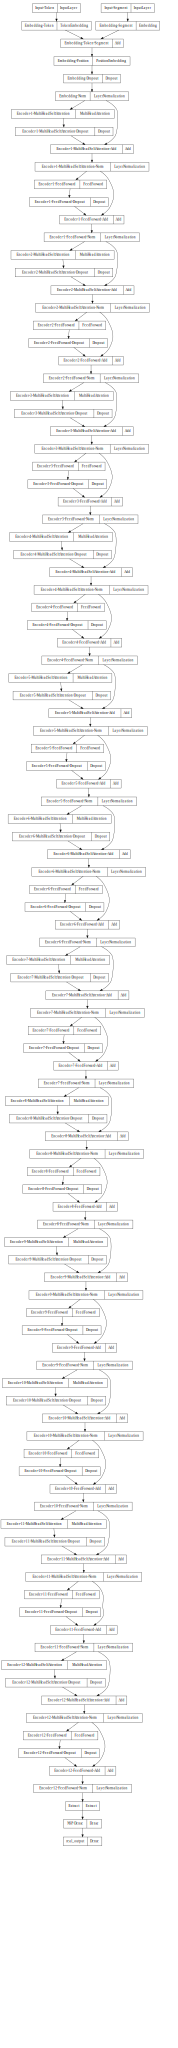

In [45]:
import pydot
import graphviz
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

s = get_bert_finetuning_model(model)
print(type(s))

t = tf.keras.utils.model_to_dot(s, dpi=65)
print(type(t))

#SVG(t.create(prog='dot', format='svg'))

In [47]:
#sess = K.get_session()
#uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
#init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
#sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

Epoch 1/2
9137/9137 [==============================] - 2004s 217ms/step - loss: 0.3530 - accuracy: 0.8411 - val_loss: 0.3039 - val_accuracy: 0.8708
Epoch 2/2
9137/9137 [==============================] - 1979s 217ms/step - loss: 0.2576 - accuracy: 0.8925 - val_loss: 0.2833 - val_accuracy: 0.8811


## View the training graphs

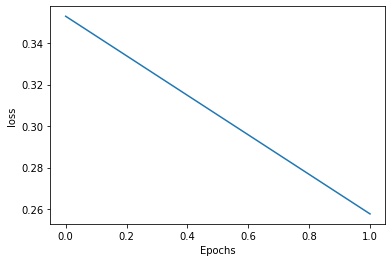

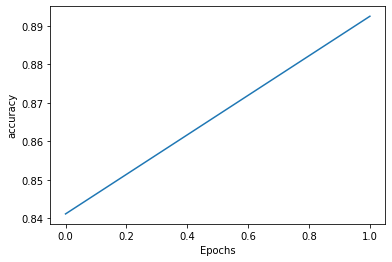

In [48]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'loss')
plot_graphs(history, 'accuracy')

In [49]:
path = "./models"
if(os.path.exists(path) == False):
    os.makedirs(path)
bert_model.save_weights(path+"/bert.h5")

In [50]:
#load the BERT model
bert_model = get_bert_finetuning_model(model)

bert_model.load_weights(path+"/bert.h5")

## Test the data

In [51]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Input given as Pandas Dataframe
    data_df = x
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x = predict_convert_data(data_df)

    return data_x

In [52]:
test_set = predict_load_data(test)
preds = bert_model.predict(test_set)

preds

100%|███████████████████████████████████| 49157/49157 [00:06<00:00, 7955.35it/s]


array([[0.9717476 ],
       [0.7296616 ],
       [0.22660169],
       ...,
       [0.05068037],
       [0.00281329],
       [0.04336803]], dtype=float32)

In [55]:
from sklearn.metrics import classification_report

y_true = test['label']
# F1 Score 
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     24446
           1       0.90      0.86      0.88     24711

    accuracy                           0.88     49157
   macro avg       0.88      0.88      0.88     49157
weighted avg       0.88      0.88      0.88     49157



In [56]:
def get_feature_map(model):
  inputs = model.input
  outputs = model.layers[-2].output
  feature_model = Model(inputs, outputs)
  return feature_model

In [57]:
bert_feature = get_feature_map(bert_model)

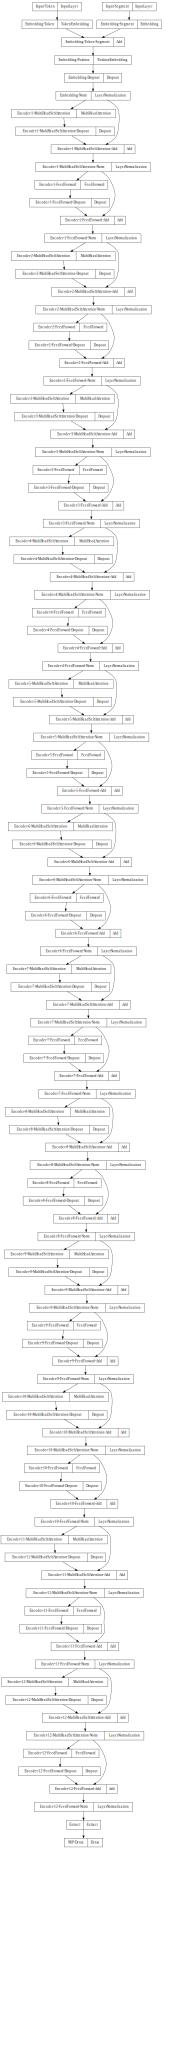

In [58]:
SVG(model_to_dot(bert_feature, dpi=65).create(prog='dot', format='svg'))

In [59]:
bert_weight_list = bert_feature.predict(test_set)

In [62]:
print(bert_weight_list)
print(bert_weight_list.shape)

(49157, 768)


In [66]:
labels = test['label']

In [67]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [68]:
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=3).fit_transform(bert_embedded)
bert_embedded

array([[  2.6475327 , -16.753859  ,   5.584986  ],
       [  0.38764456,   9.602343  ,   3.9387355 ],
       [ -0.08618566,   4.6346526 , -18.800571  ],
       ...,
       [ -5.8778086 ,   9.260776  ,  -4.172697  ],
       [-13.737574  ,  -6.2933455 ,  -0.8486692 ],
       [ -4.5006747 ,   4.9531307 ,  -3.2237377 ]], dtype=float32)

In [69]:
with open(path+"/bertembedding.pkl", "wb") as f:
  pickle.dump(bert_embedded, f)

In [70]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import seaborn as sns

In [71]:
test

id                                           document  label
0      6270596                                                굳 ㅋ      1
1      9274899                               GDNTOPCLASSINTHECLUB      0
2      8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3      6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4      6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0
...        ...                                                ...    ...
49152  4608761          오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함      1
49153  5308387       의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO      0
49154  9072549                 그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다      0
49155  5802125     절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네      0
49156  6070594                                         마무리는 또 왜이래      0

[49157 rows x 3 columns]

In [72]:
def get_tsne_plot(rot1=-20, rot2=100):
  fig = plt.figure(figsize=(5,5))
  ax = Axes3D(fig)
  colors = 'b', 'r'
  labels = 0, 1
  for i, c, label in zip(range(np.shape(bert_embedded)[0]), colors, labels):
    ax.scatter(bert_embedded[test['label']==label,0], bert_embedded[test['label']==label,1], bert_embedded[test['label']==label,2], s=2, c=c, alpha=0.5)
  ax.view_init(rot1, rot2)
  print("rot1:%d" % rot1, "rot2:%d" % rot2)
  plt.legend(labels, loc='upper right')
  plt.show()

rot1:-180 rot2:-180


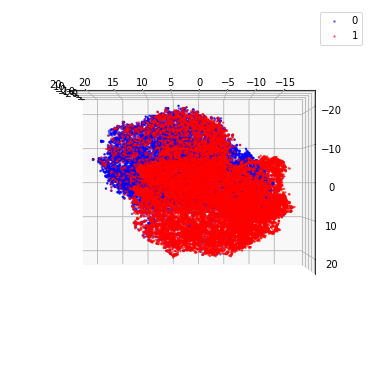

rot1:-135 rot2:-180


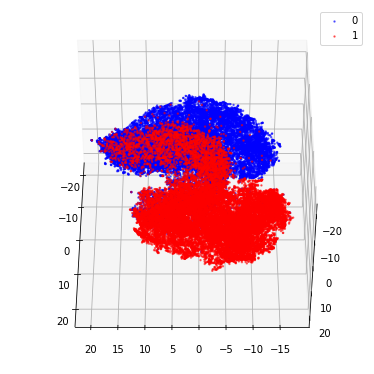

rot1:-90 rot2:-180


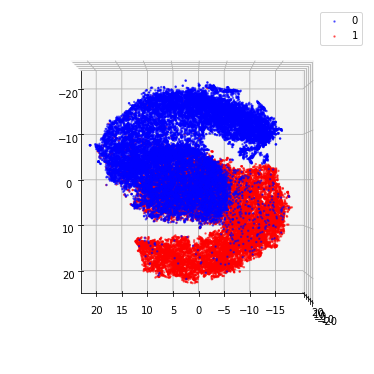

rot1:-45 rot2:-180


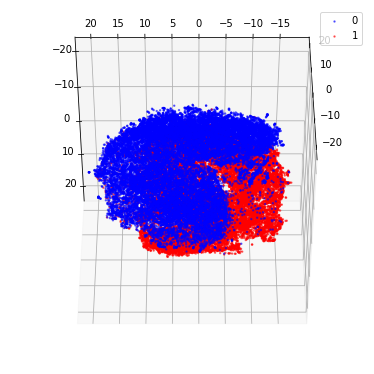

rot1:0 rot2:-180


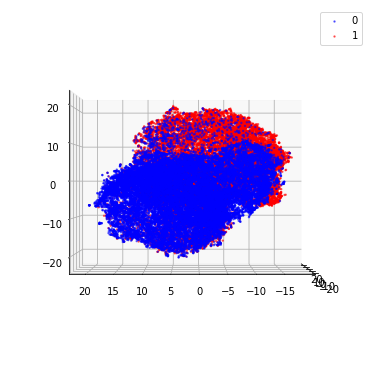

rot1:45 rot2:-180


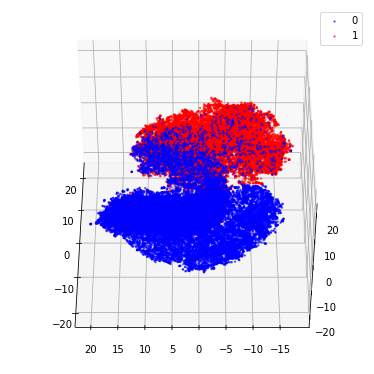

rot1:90 rot2:-180


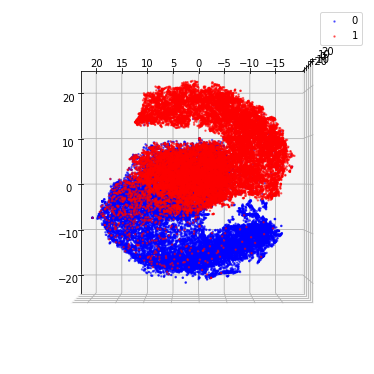

rot1:135 rot2:-180


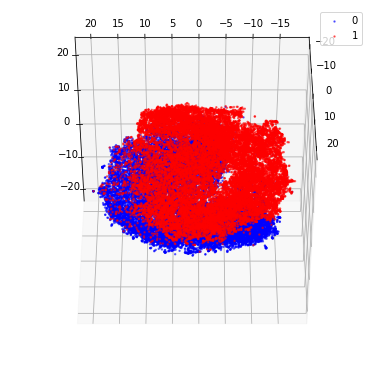

rot1:-180 rot2:-135


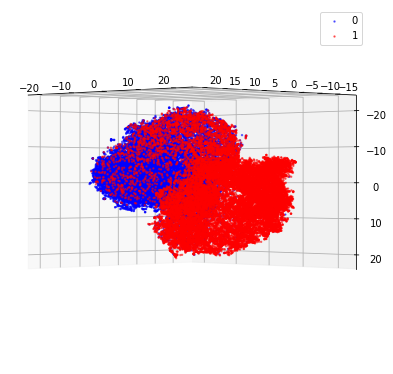

rot1:-135 rot2:-135


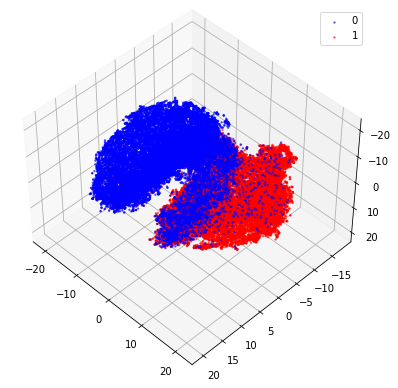

rot1:-90 rot2:-135


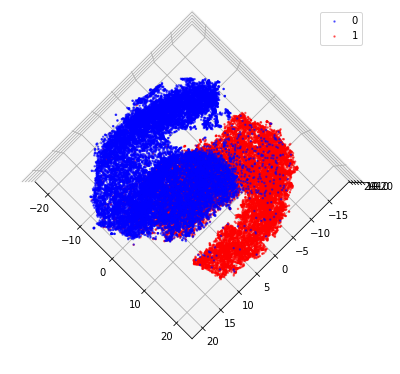

rot1:-45 rot2:-135


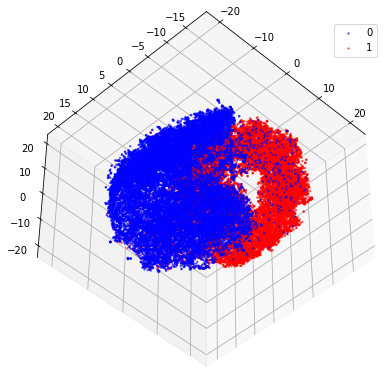

rot1:0 rot2:-135


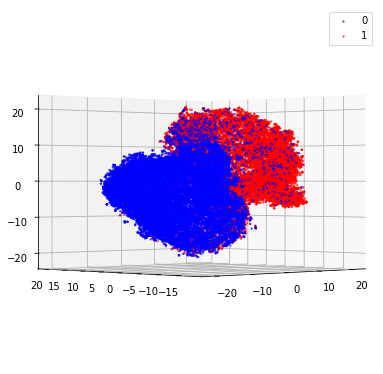

rot1:45 rot2:-135


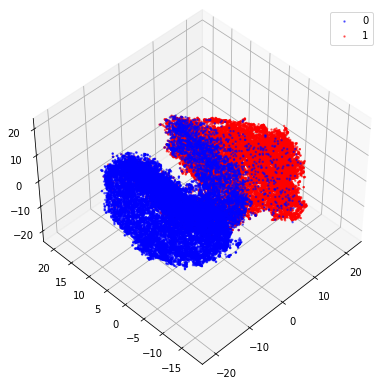

rot1:90 rot2:-135


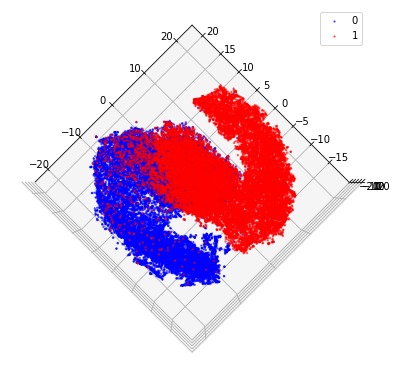

rot1:135 rot2:-135


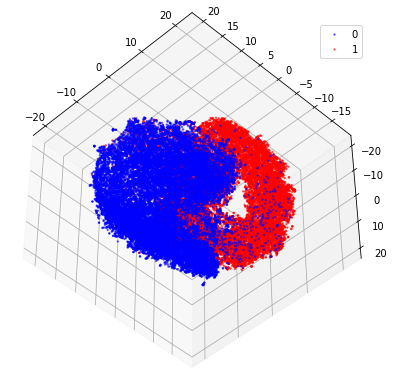

rot1:-180 rot2:-90


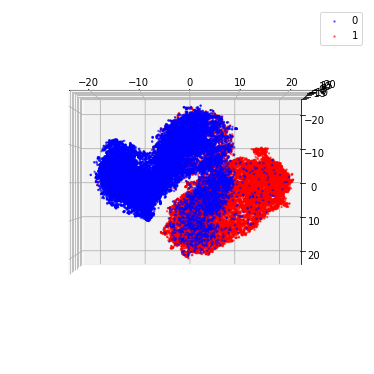

rot1:-135 rot2:-90


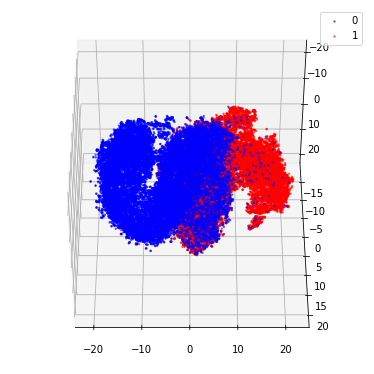

rot1:-90 rot2:-90


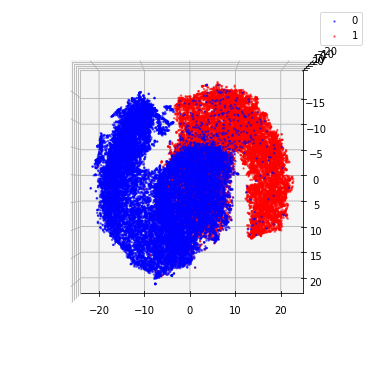

rot1:-45 rot2:-90


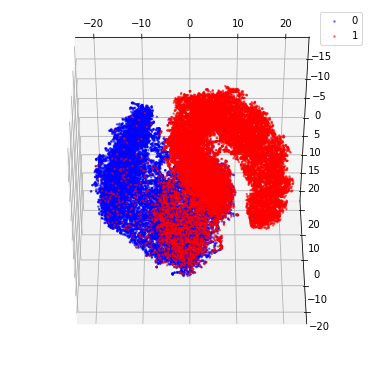

rot1:0 rot2:-90


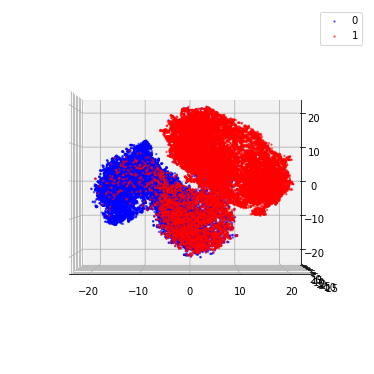

rot1:45 rot2:-90


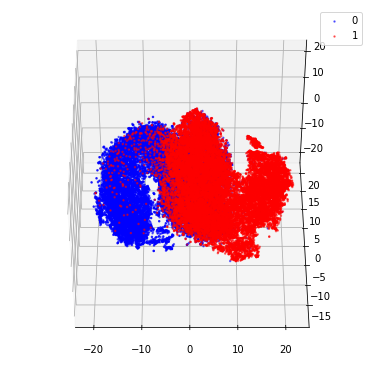

rot1:90 rot2:-90


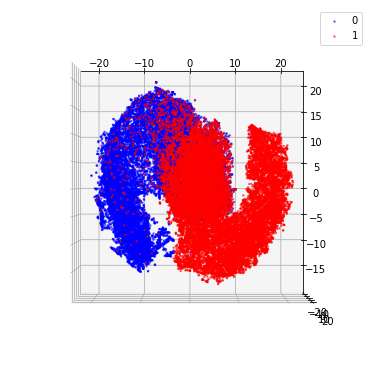

rot1:135 rot2:-90


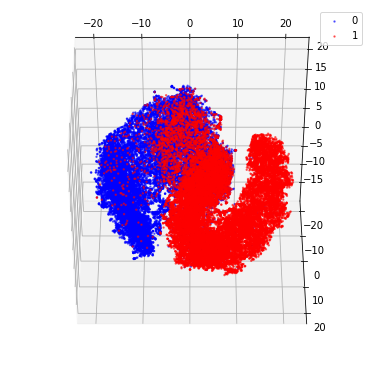

rot1:-180 rot2:-45


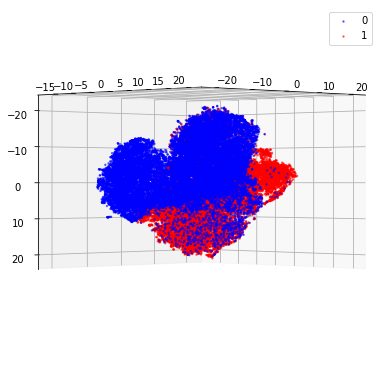

rot1:-135 rot2:-45


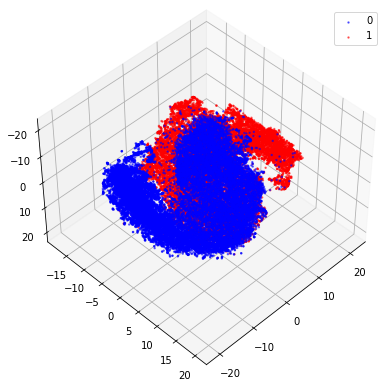

rot1:-90 rot2:-45


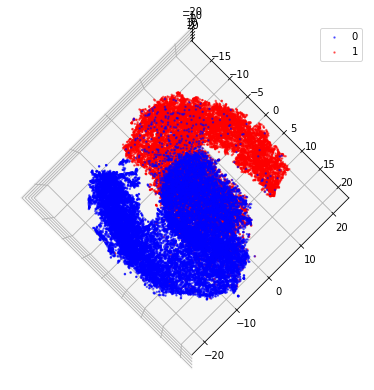

rot1:-45 rot2:-45


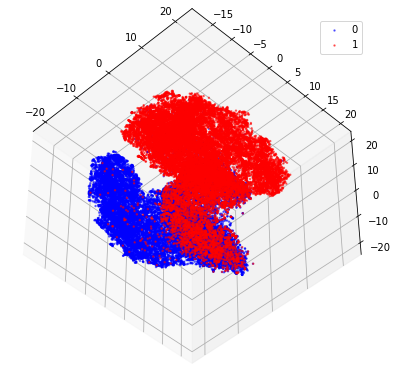

rot1:0 rot2:-45


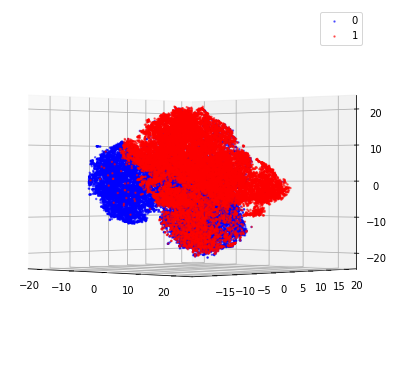

rot1:45 rot2:-45


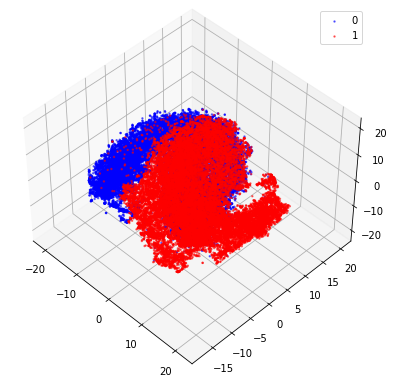

rot1:90 rot2:-45


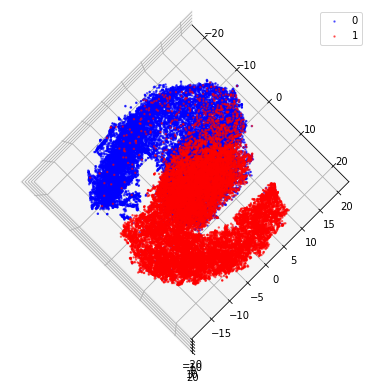

rot1:135 rot2:-45


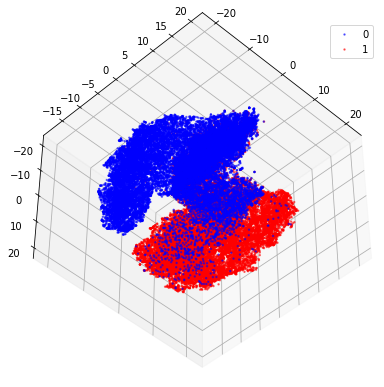

rot1:-180 rot2:0


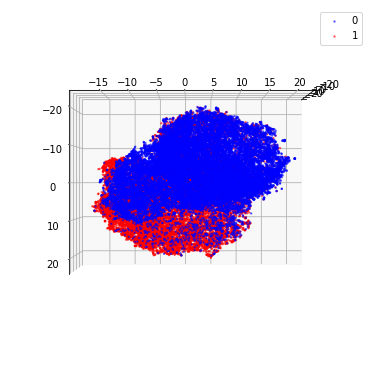

rot1:-135 rot2:0


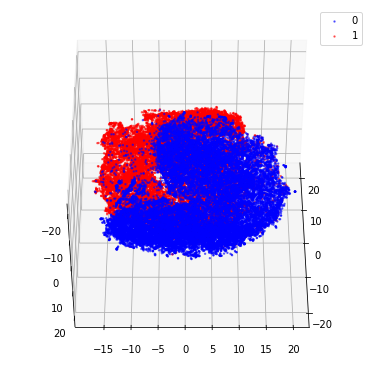

rot1:-90 rot2:0


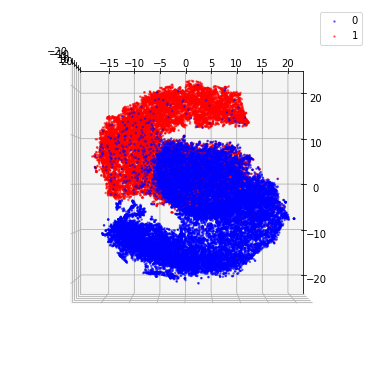

rot1:-45 rot2:0


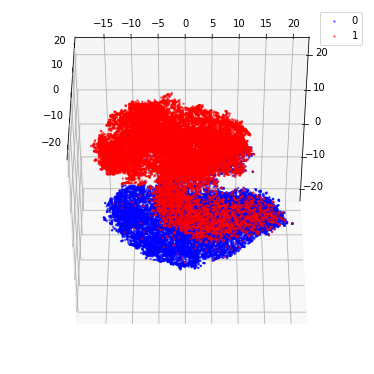

rot1:0 rot2:0


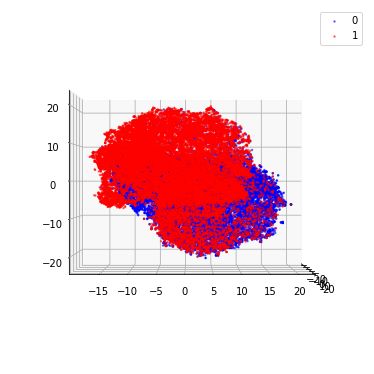

rot1:45 rot2:0


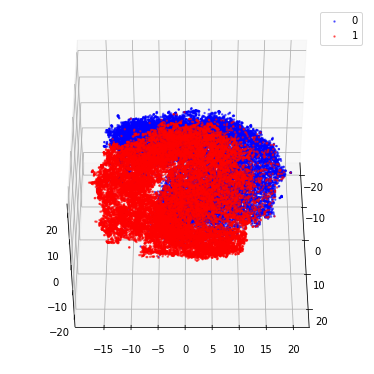

rot1:90 rot2:0


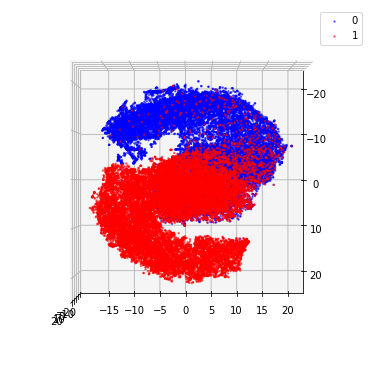

rot1:135 rot2:0


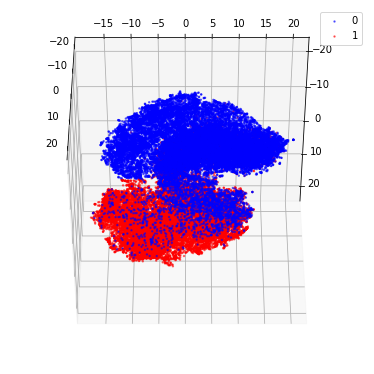

rot1:-180 rot2:45


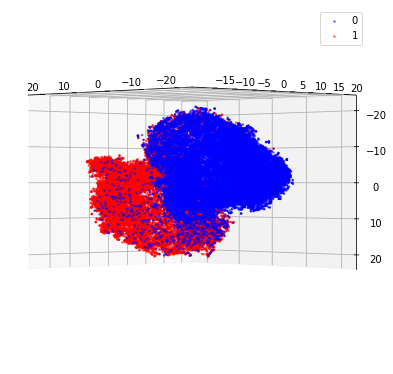

rot1:-135 rot2:45


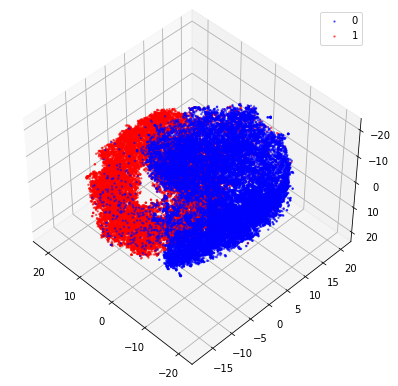

rot1:-90 rot2:45


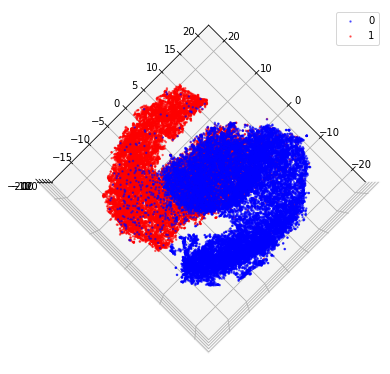

rot1:-45 rot2:45


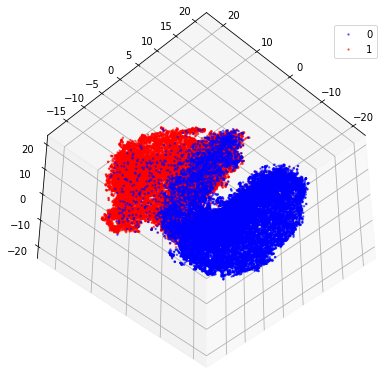

rot1:0 rot2:45


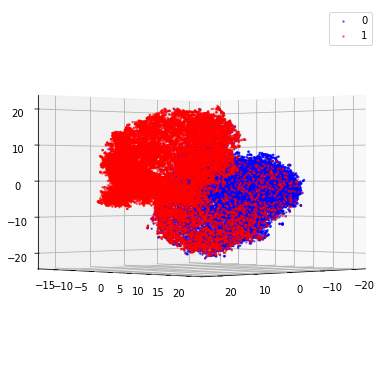

rot1:45 rot2:45


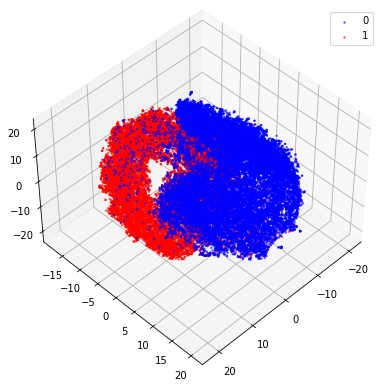

rot1:90 rot2:45


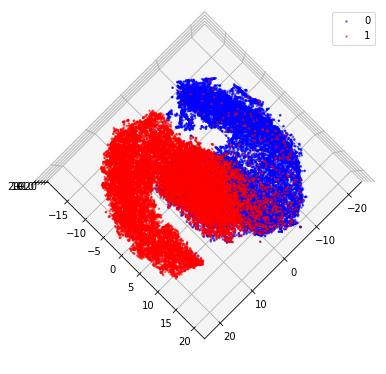

rot1:135 rot2:45


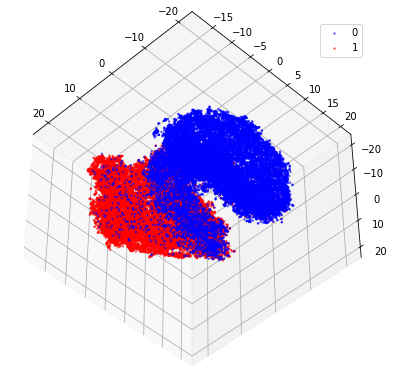

rot1:-180 rot2:90


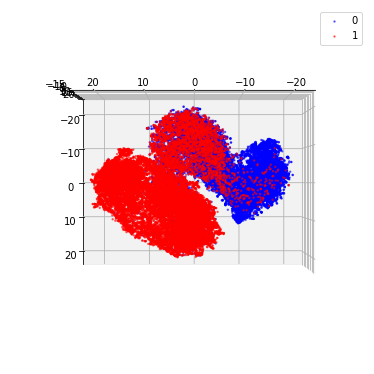

rot1:-135 rot2:90


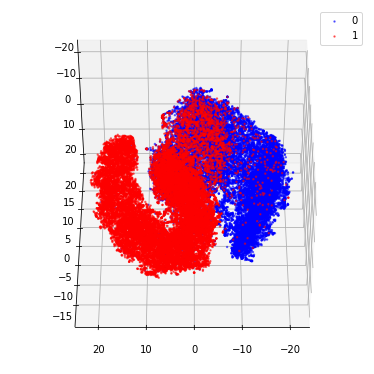

rot1:-90 rot2:90


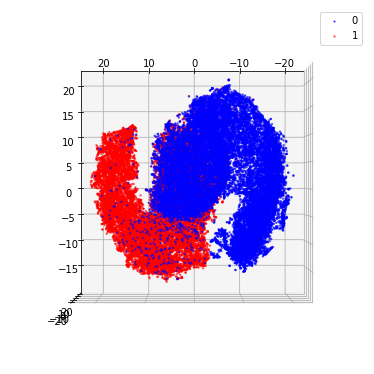

rot1:-45 rot2:90


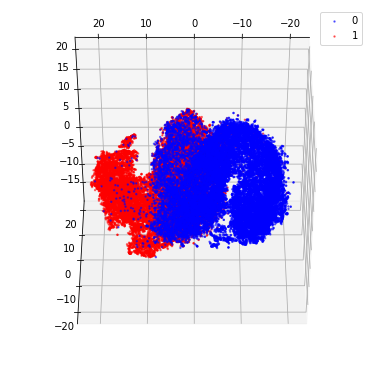

rot1:0 rot2:90


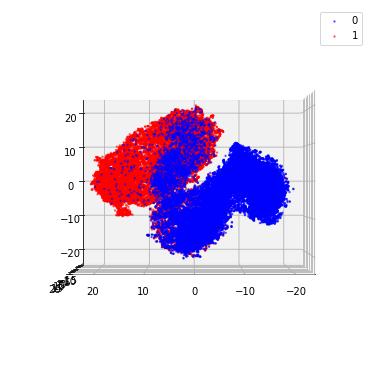

rot1:45 rot2:90


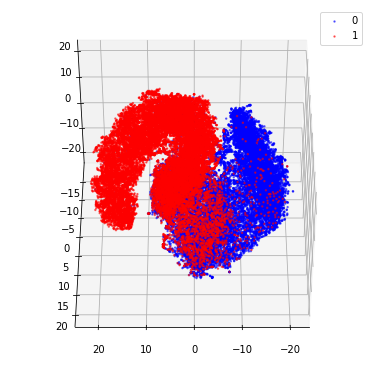

rot1:90 rot2:90


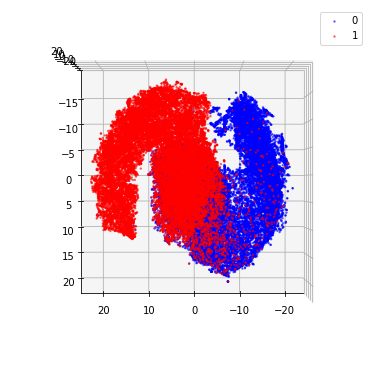

rot1:135 rot2:90


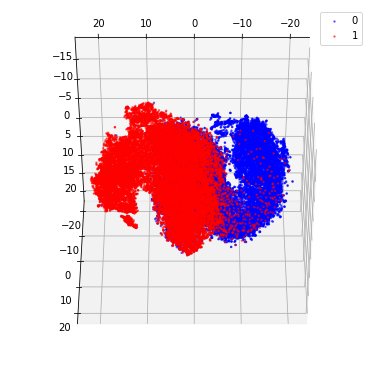

rot1:-180 rot2:135


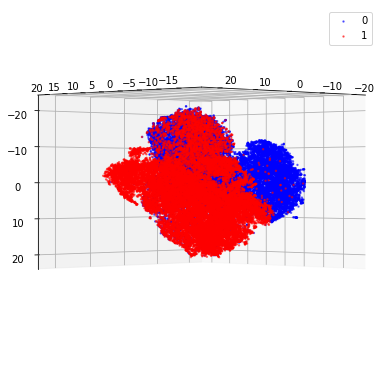

rot1:-135 rot2:135


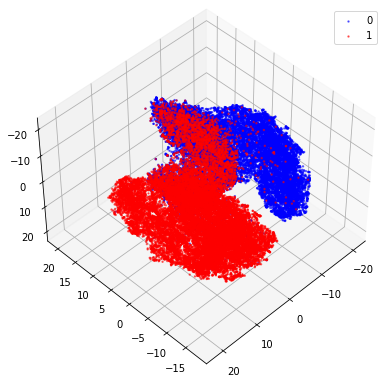

rot1:-90 rot2:135


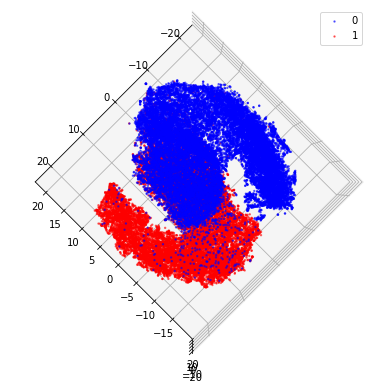

rot1:-45 rot2:135


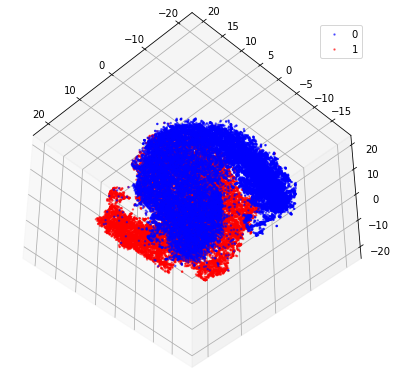

rot1:0 rot2:135


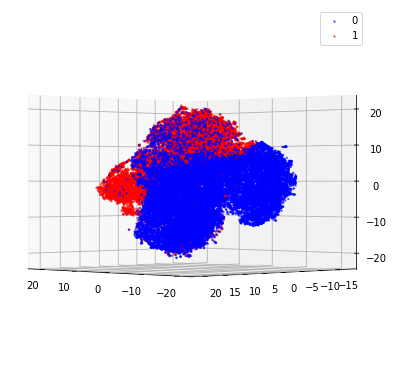

rot1:45 rot2:135


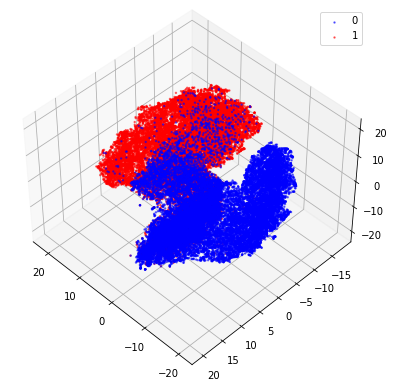

rot1:90 rot2:135


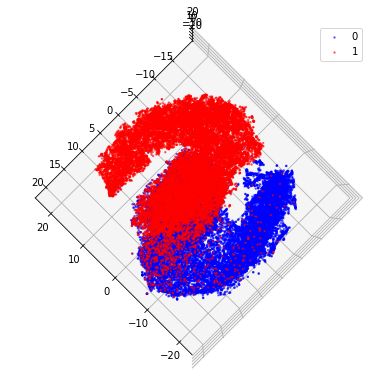

rot1:135 rot2:135


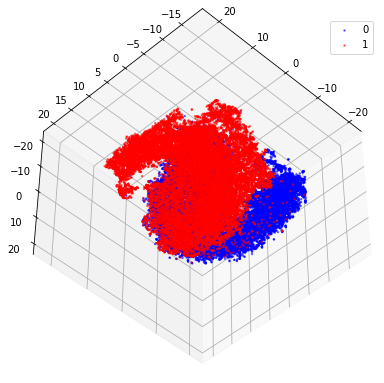

In [73]:
import time
for j in range(-180, 180, 45):
  for i in range(-180,180,45):
  
    get_tsne_plot(i, j)

In [107]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    ids, segments = tokenizer.encode(data, max_len=SEQ_LEN)
    indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def movie_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = bert_model.predict(data_x)
    print(sentence, np.ravel(predict), end='')
    predict_answer = np.ravel(predict) #np.round(np.ravel(predict), 0).item()
    
    if predict_answer < 0.4 :
      print("부정적 답변.")
    elif predict_answer > 0.6 :
      print("긍정적 답변.")
    else :
        print("어정쩡한 답변.")

In [109]:
movie_evaluation_predict("나만 이걸 보고 울었는지 모르겠지만 우리의 슬픈 역사속에서 지켜 본 왕과 신하의 신뢰와 믿음... 그 모든것이 절 슬프게 하였네요... ")
movie_evaluation_predict("너무잼있어엉 진짜 연기가 예술이고 다시보고싶은영화")
movie_evaluation_predict("처음엔 재미있었는 데 중간부터 템포가 느려지면서 졸려 죽을 뻔함")

너무잼있어엉 진짜 연기가 예술이고 다시보고싶은영화 [0.99502546]긍정적 답변.


In [111]:
movie_evaluation_predict("오늘 아침 혼자 양치하고 세수했어요.  잠자리도 혼자 정리했죠.")
movie_evaluation_predict("혼자 차타는 게 정말 힘들어요. 도와주면 몰라도")
movie_evaluation_predict("생선 좋아하고, 가시를 발라주면 잘 먹어요")
movie_evaluation_predict("샤워하는 건 어렵지 않지만 수건으로 닦는 게 힘들죠. 어깨가 아프니까")
movie_evaluation_predict("일찍 자고 일찍 일어나죠.  잠은 잘자는 편입니다")
movie_evaluation_predict("어제 밤 친구랑 술 마셨는 데 기분은 좋았지만, 아침에 배 아파서 혼났지")
movie_evaluation_predict("어제 밤 친구랑 술 마셨는 데 오랜만에")

오늘 아침 혼자 양치하고 세수했어요.  잠자리도 혼자 정리했죠. [0.76473975]긍정적 답변.
혼자 차타는 게 정말 힘들어요. 도와주면 몰라도 [0.15109807]부정적 답변.
생선 좋아하고, 가시를 발라주면 잘 먹어요 [0.51839656]어정쩡한 답변.
샤워하는 건 어렵지 않지만 수건으로 닦는 게 힘들죠. 어깨가 아프니까 [0.2626907]부정적 답변.
일찍 자고 일찍 일어나죠.  잠은 잘자는 편입니다 [0.23408353]부정적 답변.
어제 밤 친구랑 술 마셨는 데 기분은 좋았지만, 아침에 배 아파서 혼났지 [0.3803841]부정적 답변.
어제 밤 친구랑 술 마셨는 데 오랜만에 [0.4390865]어정쩡한 답변.


In [ ]:
movie_evaluation_predict("생선 좋아함. 가시를 발라주면 먹음")
movie_evaluation_predict("생선 좋아함. 가시 발라낼 수 없어서 피함")
movie_evaluation_predict("생선 좋아함. 소고기만 나옴")